# Welcome to Pynq Audio
This notebook shows the basic recording and playback features of the board.  
It uses the audio jack to play back recordings from the built-in microphone, as well as a pre-recorded audio sample. Moreover, visualization with matplotlib and playback with IPython.Audio are shown.
## Create new audio object

In [1]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")
pAudio = base.audio

## Record and save
Record a 3-second sample and save it into a file.

In [2]:
pAudio.record(3)
pAudio.save("Recording_1.pdm")

## Load and play
Load a sample and play the loaded sample.

In [3]:
pAudio.load("/home/xilinx/pynq/lib/tests/pynq_welcome.pdm")
pAudio.play()

## Play in notebook
Users can also play the audio directly in notebook. To do this, the file format has to be converted from Pulse Density Modulation (PDM) to Pulse Code Modulation (PCM). 

For more information, please refer to: https://en.wikipedia.org/wiki/Pulse-density_modulation.

### Step 1: Preprocessing
In this step, we first convert the 32-bit integer buffer to 16-bit. Then we divide 16-bit words (16 1-bit samples each) into 8-bit words with 1-bit sample each.

In [4]:
import time
import numpy as np

start = time.time()
af_uint8 = np.unpackbits(pAudio.buffer.astype(np.int16)
                         .byteswap(True).view(np.uint8))
end =  time.time()

print("Time to convert {:,d} PDM samples: {:0.2f} seconds"
      .format(np.size(pAudio.buffer)*16, end-start))
print("Size of audio data: {:,d} Bytes"
      .format(af_uint8.nbytes))

Time to convert 10,720,000 PDM samples: 0.08 seconds
Size of audio data: 10,720,000 Bytes


### Step 2: Converting PDM to PCM
We now convert PDM to PCM by decimation. The sample rate is reduced from 3MHz to 32kHz.

We will remove the first and last 10 samples in case there are outliers introduced by decimation. We will also remove the DC offset from the waveform.

In [5]:
import time
from scipy import signal

start = time.time()
af_dec = signal.decimate(af_uint8,8,zero_phase=True)
af_dec = signal.decimate(af_dec,6,zero_phase=True)
af_dec = signal.decimate(af_dec,2,zero_phase=True)
af_dec = (af_dec[10:-10]-af_dec[10:-10].mean())
end = time.time()
print("Time to convert {:,d} Bytes: {:0.2f} seconds"
      .format(af_uint8.nbytes, end-start))
print("Size of audio data: {:,d} Bytes"
      .format(af_dec.nbytes))
del af_uint8

Time to convert 10,720,000 Bytes: 7.89 seconds
Size of audio data: 893,176 Bytes


### Step 3: Audio Playback in Web Browser

In [6]:
from IPython.display import Audio as IPAudio
IPAudio(af_dec, rate=32000)

## Plotting PCM data

Users can display the audio data in notebook:

1. Plot the audio signal's amplitude over time.
2. Plot the spectrogram of the audio signal.

#### Amplitude over time

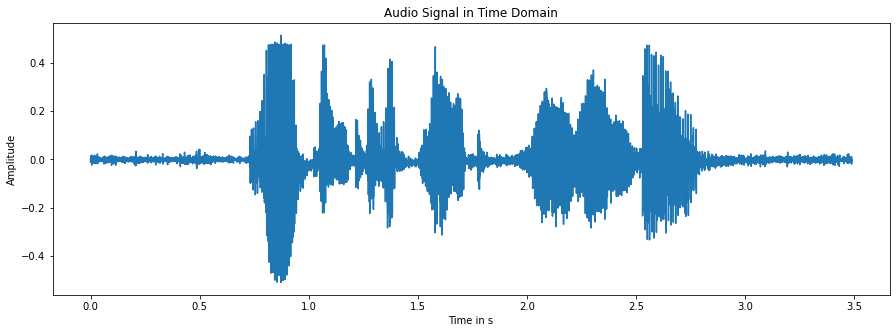

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(15, 5))
time_axis = np.arange(0,((len(af_dec))/32000),1/32000)
plt.title('Audio Signal in Time Domain')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.plot(time_axis, af_dec)
plt.show()

#### Frequency spectrum

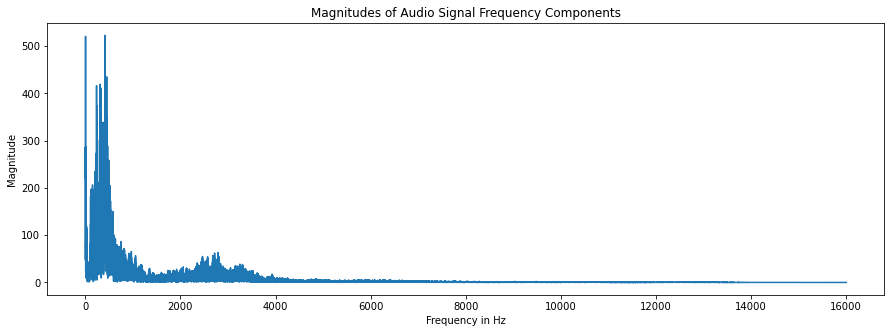

In [8]:
from scipy.fftpack import fft

yf = fft(af_dec)
yf_2 = yf[1:len(yf)//2]
xf = np.linspace(0.0, 32000//2, len(yf_2))

plt.figure(num=None, figsize=(15, 5))
plt.plot(xf, abs(yf_2))
plt.title('Magnitudes of Audio Signal Frequency Components')
plt.xlabel('Frequency in Hz')
plt.ylabel('Magnitude')
plt.show()

#### Frequency spectrum over time
Use the `classic` plot style for better display.

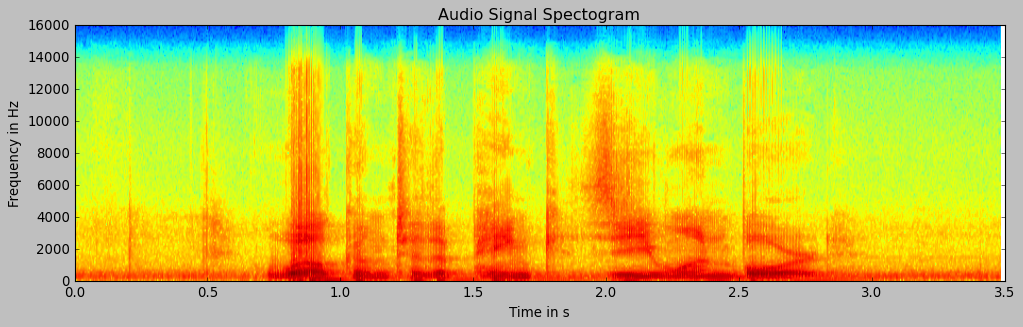

In [9]:
import matplotlib

np.seterr(divide='ignore',invalid='ignore')
matplotlib.style.use("classic")
plt.figure(num=None, figsize=(15, 4))
plt.title('Audio Signal Spectogram')
plt.xlabel('Time in s')
plt.ylabel('Frequency in Hz')
_ = plt.specgram(af_dec, Fs=32000)